In [5]:
from mlxtend.data import loadlocal_mnist
import platform
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch
import torch.utils.data as data
import torch.optim as optim
import sklearn.metrics
import skimage
import skimage.transform

ModuleNotFoundError: No module named 'torch'

In [2]:
# Load MNIST Dataset

X_train, y_train = loadlocal_mnist(
            images_path='train-images.idx3-ubyte', 
            labels_path='train-labels.idx1-ubyte')

X_test, y_test = loadlocal_mnist(
            images_path='t10k-images.idx3-ubyte', 
            labels_path='t10k-labels.idx1-ubyte')

X_train = np.resize(X_train, (60000, 28, 28))
X_test = np.resize(X_test, (10000, 28, 28))

y_train = nn.functional.one_hot(torch.tensor(y_train).long())
y_test = nn.functional.one_hot(torch.tensor(y_test).long())

Lable: tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])


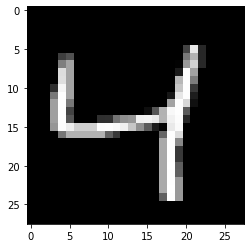

In [3]:
# Plot Example

img_nr = 2

print('Lable:', y_train[img_nr])

image = X_train[img_nr]

fig = plt.figure
plt.imshow(image, cmap='gray')
plt.show()

In [4]:
# Create Dataset for Batchlearning

class BasicDataset(data.Dataset):
    def __init__(self, X, y):
        self.X = np.expand_dims(X, axis=1)
        self.y = y
        
        
    
    def __getitem__(self, idx):
        return dict(X=self.X[idx], y=self.y[idx])
    
    def __len__(self):
        return self.X.shape[0]

In [5]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.model = nn.Sequential(nn.Conv2d(1, 3, 3, 2),
                                   nn.ReLU(),
                                   nn.Conv2d(3, 3, 3, 2),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2, 1),
                                   nn.Flatten(1,3),
                                   nn.Linear(75, 50),
                                   nn.ReLU(),
                                   nn.Linear(50, 20),
                                   nn.ReLU(),
                                   nn.Linear(20, 10), 
                                   nn.Softmax(1))
    

    def forward(self, x):
        out = self.model(torch.Tensor(x))
        #out = torch.argmax(out, dim=1)
        return out.unsqueeze(0)
        
    def train(self, dataset, learning_rate, batch_size, epochs): 
        optimizer = optim.Adam(self.model.parameters())

        # Train linear model using SGD on mini-batches.
        for epoch in range(epochs):
            # DataLoader generates random batches from a given dataset.
            data_loader = data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, drop_last=True)
             # We want to report the training loss after each epoch
            epoch_loss = 0.0 

            for batch in data_loader:
                # After each iteration of the training step, reset the local gradients stored in the network to zero.
                self.model.zero_grad()
                self.model.zero_grad()
                
                # Compute the forward pass.
                # Numpy uses doubles by default but Torch expects floats, since the added accuracy of doubles 
                # is generally not useful for neural networks.
                # We fix this issue by changing the datatype of 'X' and 'y' with the .float method.
                yhat = self.model.forward(batch['X'].float())

                # Compute the batch error.
                loss = nn.BCELoss()

                batch_loss = loss(yhat, batch['y'].float())
                #F.cross_entropy(yhat, batch['y'].long())
                #batch_loss = F.mse_loss(yhat, batch['y'].float())
                epoch_loss += batch_loss.item()

                # Backpropagate the gradient and adjust the weights.
                batch_loss.backward()
                optimizer.step()

            print(f'Epoch {epoch+1}/{epochs} - Loss: {round(epoch_loss, 3)}')
        

In [10]:
MyCNN = CNN()

training_dataset = BasicDataset(X_train, y_train)

MyCNN.forward(np.expand_dims(X_train[:1], axis=1))

tensor([[[0.1668, 0.0711, 0.0629, 0.0650, 0.0519, 0.1338, 0.1780, 0.0703,
          0.0786, 0.1216]]], grad_fn=<UnsqueezeBackward0>)

In [11]:
MyCNN.train(training_dataset, 0.1, 1000, 10)

Epoch 1/10 - Loss: 15.528
Epoch 2/10 - Loss: 5.847
Epoch 3/10 - Loss: 4.029
Epoch 4/10 - Loss: 3.269
Epoch 5/10 - Loss: 2.794
Epoch 6/10 - Loss: 2.407
Epoch 7/10 - Loss: 2.116
Epoch 8/10 - Loss: 1.913
Epoch 9/10 - Loss: 1.781
Epoch 10/10 - Loss: 1.667


In [12]:
y_hat = MyCNN.forward(torch.tensor(np.expand_dims(X_test[:10], axis=1)).float()).squeeze(0)

print(torch.argmax(y_hat, dim=1))
print(torch.argmax(y_test[:10], dim=1))

tensor([7, 2, 1, 0, 4, 1, 4, 9, 6, 9])
tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])


tensor([7, 2, 1,  ..., 4, 5, 6])
tensor([7, 2, 1,  ..., 4, 5, 6])
Precision: 0.952457619365991
Recall: 0.9522596223488143
F1: 0.9522511467828118


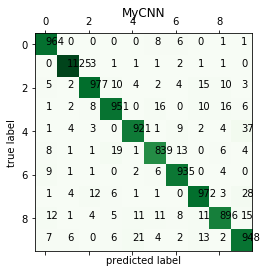

In [13]:
y_hat = MyCNN.forward(torch.tensor(np.expand_dims(X_test, axis=1)).float()).squeeze(0)

y_hat = torch.argmax(y_hat, dim=1)
y_test1 = torch.argmax(y_test, dim=1)

print(y_hat)
print(y_test1)

def plot_confusion_matrix(cmatrix, classifier_name):
    import matplotlib.pyplot as plt
    
    fig, ax = plt.subplots(1, 1)
    ax.matshow(cmatrix, cmap='Greens')
    for x in range(10):
        for y in range(10):
            ax.text(x, y, cmatrix[y, x])
    ax.set_xlabel('predicted label')
    ax.set_ylabel('true label')
    ax.set_title(classifier_name)

cm = sklearn.metrics.confusion_matrix(y_test1, y_hat.detach().numpy())
plot_confusion_matrix(cm, "MyCNN")
precision, recall, f1, _ = sklearn.metrics.precision_recall_fscore_support(y_test1, y_hat.detach().numpy())
print("Precision:", np.mean(precision))
print("Recall:", np.mean(recall))
print("F1:", np.mean(f1))

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


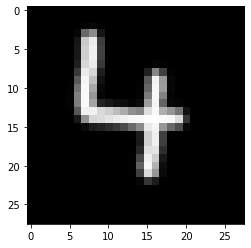

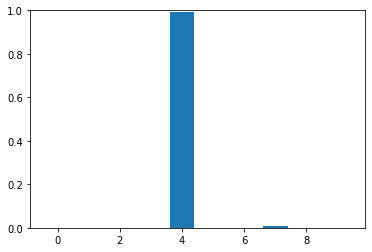

[ 0.   0.1  0.   0.  99.1  0.   0.   0.7  0.   0.1]


In [14]:
import pygame as pg
import math
pg.init()

(width, height) = (280, 280)
screen = pg.display.set_mode((width, height))
screen.fill((255, 255, 255))
pg.display.flip()



running = True
while running:
    pg.display.flip()
    for event in pg.event.get():
        if event.type == pg.MOUSEMOTION:
            if event.buttons == (1, 0, 0):
                pos = pg.mouse.get_pos()
                #x = math.floor(pos[0]/10)*10
                #y = math.floor(pos[1]/10)*10
                #pg.draw.rect(screen, (0,0,0), (x, y, 10, 10))
                pg.draw.circle(screen, (0,0,0), pos, 10, 10)
            
              
        if event.type == pg.QUIT:
            running = False
            
        if event.type == pg.KEYDOWN:
            if event.key == pg.K_q:
                running = False
                


img = pg.surfarray.array2d(screen)
img = img/16777215*255
img = np.array(img.T)
img = skimage.transform.resize(img, (28, 28))
img = np.rint(255 - img)

pg.display.quit()

plt.imshow(img, cmap='gray')
plt.show()

out = MyCNN.forward(np.expand_dims(np.expand_dims(img, axis=0), axis=0))
#out = torch.argmax(out, dim=2)
out = out.detach().numpy().squeeze(0).squeeze(0)
plt.bar(range(0, 10), out)
plt.ylim(0, 1)
plt.show()

print(np.around(out*100, decimals=1))

In [ ]:
test1